In [21]:
from IPython.display import display, clear_output, Image
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
from pathlib import Path
import gymnasium as gym
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [22]:
# import os  # needed if running torch.compile(), remember to also use VS build tools
# compiler_path = r"C:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.43.34808\bin\Hostx64\x64"
# os.environ["PATH"] = compiler_path + ";" + os.environ.get("PATH", "")

In [28]:
env = gym.make('CliffWalking-v0', render_mode='human')

In [29]:
env.unwrapped.render_mode = 'human'

state, info = env.reset()
for step in range(50):
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    
    clear_output(wait=True)
    print('taking action', action, ' into state', state, ' got reward', reward)

    if done or truncated:
        print(f"Episode finished with environment reward: {reward}")
        break

taking action 0  into state 12  got reward -1


In [5]:
print(env.action_space)
print(env.observation_space.shape)
print(env.observation_space)

Discrete(4)
()
Discrete(48)


# DDQN with soft updates to target network

In [6]:
class ReplayBuffer:
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)

    def __len__(self): 
        return len(self.buffer)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def clear(self):
        self.buffer.clear()

    def sample(self, batch_size):
        assert batch_size <= len(self), 'sample size is greater than population of buffer'
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))  # with replacement
        # converting to ndarray then to tensor is probably faster than directly to tensor
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)  

In [7]:
class Globals:
    initialized = False
    episode_count = 0
    step_count = 0  # counts the steps the agent actually sees (not 'real' emulator steps)

    @classmethod
    def reset(cls):
        cls.initialized = False
        cls.episode_count = 0
        cls.step_count = 0
        

# to be initialized
    # target_net
    # online_net
    # memory
    # etc.

In [8]:
class QNetwork(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_in, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, n_out)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [39]:
class Agent:
    def __init__(self, env, state, log_dir='runs/?'):
        self.env = env
        self.state = state
        self.action_d = self.env.action_space.n
        self.state_d = self.env.observation_space.n  # we will one-hot encode since space is discrete(n) here
        
        self.gamma = 0.99
        self.learn_freq = 4
        self.sync_freq = 4
        self.tau = 0.002  # percentage of 'new' parameters in soft updates
        self.batch_size = 64
        
        self.start_samples = 1000  # start training after X samples

        # self.eps_max = 1   # see `get_current_epsilon` method for epsilon schedule
        # self.eps_min = 0.01
        # self.eps_anneal_steps = 50_000

        if not Globals.initialized:
            Globals.memory = ReplayBuffer(100_000)  # memory buffer size

            self.initialize_nets()
            Globals.initialized = True
        
        self.optimizer = optim.AdamW(Globals.online_net.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

        # set to float('inf') to disable, seems sus for DQN as it could prevent estimation of optimal large Q values - it's also not "real" clipping
        self.max_grad_norm = float('inf')  

        self.early_stopping_patience = 100  # stop training after X episodes with mean return >= Y
        self.early_stopping_return = 999

        self.action_repeat = 1
        self.max_steps = 500  # per episode

        # meta / tracking
        self.avg_beta = 0.95  # used for moving average calculation on graph
        self.start_step_count = Globals.step_count
        self.start_episode_count = Globals.episode_count
        self.eps_shift = 0
        
        if log_dir[-1] == '?':
            log_dir = log_dir[:-1] + self.env.spec.id + '-' + datetime.now().strftime('%Y-%m-%d') + '-v0'
        while Path(log_dir).is_dir():
            log_dir = log_dir[:-1] + str(int(log_dir[-1]) + 1)
        self.log_dir = log_dir
        self.writer = SummaryWriter(log_dir=self.log_dir)
        self.writer.add_graph(Globals.online_net, torch.randn(1, self.state_d))  # cheap -- only 1 forward pass
        self.writer.close()
    
    def get_current_epsilon(self):
        # return max(self.eps_min, self.eps_min + (self.eps_max - self.eps_min) 
        #           * (1 - Globals.step_count/self.eps_anneal_steps))  # linear annealing
        return max(0.00, 0.99998 ** (Globals.step_count - self.eps_shift))  # exponential decay

    
    def reset_epsilon(self):
        self.eps_shift = Globals.step_count
    

    def initialize_nets(self):
        Globals.online_net = QNetwork(self.state_d, self.action_d)
        Globals.target_net = QNetwork(self.state_d, self.action_d)
        Globals.target_net.eval()  # good practice in case there are dropout/batchnorm layers
        self.sync()
        
    def save(self, path):
        torch.save(Globals.online_net.state_dict(), path)

    def load(self, path):
        Globals.online_net.load_state_dict(torch.load(path))
                
    def display_info(self, episode_idx, eval_mode=False):
        episode = episode_idx
        t = time.time() - self.t0
        
        plt.plot(self.return_history)
        xs = range(10, len(self.avg_history))  # delay avg start
        plt.plot(xs, self.avg_history[10:])
        
        clear_output(wait=True)
        if eval_mode:
            print(f'episode {episode}\t({episode/t :.1f}/s)')
        else:
            print(f'episode {episode}\t({episode/t :.1f}/s)  [total {Globals.episode_count}]')
            print(f'steps {Globals.step_count - self.start_step_count}\t({(Globals.step_count-self.start_step_count)/t :.0f}/s)' + 
                  f'  [total {Globals.step_count}]')
        print(f'time {t:.2f} s')
        print('---')
        if eval_mode:
            print(f'average return {np.mean(self.return_history):.5f}')
        else:
            print(f'epsilon {self.get_current_epsilon():.3f}')
            print(f'replay buffer size {len(Globals.memory)}')
            print(f'average return (last {self.early_stopping_patience} episodes) {np.mean(self.return_history[-self.early_stopping_patience:]):.5f}')

        plt.show()

    
    def soft_sync(self):
        if self.tau == 1:
            return sync()
        for target_param, online_param in zip(Globals.target_net.parameters(), Globals.online_net.parameters()):
            target_param.data.copy_(self.tau * online_param.data + (1-self.tau) * target_param.data) 

    def sync(self):
        Globals.target_net.load_state_dict(Globals.online_net.state_dict())

    def fill_memory(self):
        self.env.unwrapped.render_mode = None
        while len(Globals.memory) < self.start_samples:
            self.state, info = self.env.reset()
            while True:
                # repeat matters because rewards can accumulate through multiple steps
                reward, done, truncated = self.do_action_with_repeat(env.action_space.sample())  
                if done or truncated: 
                    break
            clear_output(wait=True)
            print(f'collecting initial training data {len(Globals.memory)}/{self.start_samples}')

    def greedy(self):
        with torch.no_grad():  # don't track backward gradients on inference
            x = self.state_to_one_hot(self.state)  # for state space of discrete(n)
            x = torch.tensor(x)
            Q_values = Globals.online_net(x)
            return Q_values.argmax().item()

    def epsilon_greedy(self):
        if np.random.random() < self.get_current_epsilon():
            return env.action_space.sample()
        return self.greedy()

    def state_to_one_hot(self, state, classes=-1):
        if classes == -1:
            classes = self.state_d
        one_hot = [0.0 for _ in range(classes)]
        one_hot[state] = 1.0
        return one_hot

    def do_action_with_repeat(self, action, update_memory=True):  # returns (reward, done, truncated)
        reward = 0
        for repetition in range(self.action_repeat):
            next_state, frame_reward, done, truncated, info = self.env.step(action)
            # BEGIN reward shaping
            # frame_reward += abs(self.state[1]) * 10  # speed of car
            # END
            reward += frame_reward
            if done or truncated: 
                break
        if update_memory:
            Globals.memory.push(
                self.state_to_one_hot(self.state), action, reward, self.state_to_one_hot(next_state), done
            )  # for state space of discrete(n)
        self.state = next_state
        
        return reward, done, truncated

    
    def train(self, *args, **kwargs):
        # RAII..!! guarantees safe IO
        self.writer = SummaryWriter(log_dir=self.log_dir)  
        try:
            return self._train(*args, **kwargs)
        except KeyboardInterrupt:
            self.writer.add_scalar('Training_interrupt', 1, Globals.step_count)
            # clear_output()
            print('\033[31m SIGINT detected \033[32m training state is saved in memory \033[0m')
        finally:
            self.writer.add_scalar('Training_break', 1, Globals.step_count)
            self.writer.close()
        
    def _train(self, num_episodes=100, show_chart=True):
        self.fill_memory()
        assert self.env.unwrapped.render_mode is None

        self.t0 = time.time()
        self.return_history = []
        self.avg_history = []  # moving average of return
        
        for episode in range(1, num_episodes+1):
            Globals.episode_count += 1
            
            self.state, info = self.env.reset()
            episode_return = 0

            for step in range(self.max_steps):
                Globals.step_count += 1

                action = self.epsilon_greedy()
                reward, done, truncated = self.do_action_with_repeat(action)
                episode_return += reward

                if Globals.step_count % self.sync_freq == 0:  # sync online and target networks
                    self.soft_sync()

                if Globals.step_count % self.learn_freq == 0:  # update online network
                    states, actions, rewards, next_states, dones = Globals.memory.sample(self.batch_size)
                    states = torch.tensor(states, dtype=torch.float)                   # (m, d) where m = batch_size, d = dimension of state vec
                    actions = torch.tensor(actions, dtype=torch.long).reshape(-1, 1)   # (m, 1)
                    rewards = torch.tensor(rewards, dtype=torch.float).reshape(-1, 1)  # (m, 1)
                    next_states = torch.tensor(next_states, dtype=torch.float)         # (m, d)
                    dones = torch.tensor(dones, dtype=torch.float).reshape(-1, 1)      # (m, 1)
                    assert states.shape == next_states.shape == (self.batch_size, self.state_d)
                    assert actions.shape == rewards.shape == dones.shape == (self.batch_size, 1)

                    Q_pred = Globals.online_net(states).gather(1, actions)  # predicted Q values of the states with the actions taken
                    assert Q_pred.shape == (self.batch_size, 1)

                    with torch.no_grad():
                        # select next states' best actions using online Q network (DDQN)
                        # and evaluate it using target Q network
                        argmax_next_actions = Globals.online_net(next_states).max(dim=1, keepdim=True)[1]  
                        selected_target_Q = Globals.target_net(next_states).gather(1, argmax_next_actions)
                        # If non-terminal  y = R(s) + gamma * Q_target(s', argmax_a' Q_online(s', a'))
                        # If terminal      y = R(s)  [handled by factor of (1 - dones)]
                        y = rewards + self.gamma * selected_target_Q * (1 - dones)
                        assert y.shape == (self.batch_size, 1)
                        
                    loss = self.criterion(Q_pred, y.detach())
                    self.writer.add_scalar('Loss', loss.item(), Globals.step_count)
                    
                    self.optimizer.zero_grad()
                    loss.backward()
                    
                    grad_norm = torch.nn.utils.clip_grad_norm_(Globals.online_net.parameters(), self.max_grad_norm)
                    self.writer.add_scalar('Grad_norm', grad_norm, Globals.step_count)

                    if self.max_grad_norm != float('inf'):  # if grad clipping is enabled, calculate post clip norm also
                        post_clip_norm = min(grad_norm, self.max_grad_norm)
                        self.writer.add_scalar('Clipped_grad_norm', post_clip_norm, Globals.step_count)                    
                    
                    self.optimizer.step()
                        
                if done or truncated:
                    break

            self.writer.add_scalar('Episode_return', episode_return, Globals.step_count)
            self.writer.add_scalar('Epsilon', self.get_current_epsilon(), Globals.step_count)
            
            self.return_history.append(episode_return)
            if not self.avg_history: 
                self.avg_history.append(episode_return)  # initialize with 1 element
            self.avg_history.append(self.avg_history[-1] * self.avg_beta + (1-self.avg_beta) * episode_return)

            if (  # early stopping
                np.mean(self.return_history[-self.early_stopping_patience:]) >= self.early_stopping_return
                # and Globals.episode_count - self.start_episode_count >= self.early_stopping_patience
                and len(self.return_history) >= self.early_stopping_patience
            ):
                break
                
            if episode % 5 == 0:
                self.display_info(episode)
                
        self.display_info(episode)


    def eval(self, num_episodes=500, max_steps=999999):
        self.env.unwrapped.render_mode = None
        self.t0 = time.time()
        self.return_history = []
        self.avg_history = []  # moving average of return
        
        for episode in range(1, num_episodes+1):
            self.state, info = self.env.reset()

            episode_return = 0
            for step in range(max_steps):
                action = self.greedy()
                reward, done, truncated = self.do_action_with_repeat(action, update_memory=False)
                episode_return += reward
                
                if done or truncated:
                    break
            
            self.return_history.append(episode_return)
            if not self.avg_history: 
                self.avg_history.append(episode_return)  # initialize with 1 element
            self.avg_history.append(self.avg_history[-1] * self.avg_beta + (1-self.avg_beta) * episode_return)

            if episode % 10 == 0:
                self.display_info(episode, eval_mode=True)

    def play(self):
        self.env.unwrapped.render_mode = 'human'
        Q_history = []
        reward_history = []
        total_collected_rewards = [0]
        estimated_total_return = []

        self.state, info = env.reset()
        for step in range(999999):
            # self.env.render()

            with torch.no_grad():
                x = torch.tensor(self.state_to_one_hot(self.state))  # for state space of discrete(n)
                Q_values = Globals.online_net(x)
                Q = Q_values.max().item()
                action = Q_values.argmax().item()

            reward, done, truncated = self.do_action_with_repeat(action, update_memory=True)  # add it to the replay buffer for fun

            Q_history.append(Q)
            reward_history.append(reward)
            estimated_total_return.append(total_collected_rewards[-1] + Q)
            total_collected_rewards.append(total_collected_rewards[-1] + reward)            
            
            if step % 1 == 0:
                clear_output(wait=True)
                plt.plot(Q_history, ':', label='Estimated future return')
                plt.plot(estimated_total_return, ':', label='Estimated total return')
                plt.plot(total_collected_rewards[1:], label='Total collected rewards')
                plt.plot(reward_history, label='Immediate reward')
                plt.legend()
                plt.show()
        
            if done or truncated:
                print(f"total rewards collected: {total_collected_rewards[-1]}")
                break

In [40]:
agent = Agent(env, state)

In [16]:
# Globals.reset()  # restart training

In [17]:
# agent.reset_epsilon()  # reset exploration progress

episode 515	(22.7/s)  [total 3296]
steps 83369	(3670/s)  [total 115781]
time 22.72 s
---
epsilon 0.099
replay buffer size 100000
average return (last 100 episodes) -52.63000


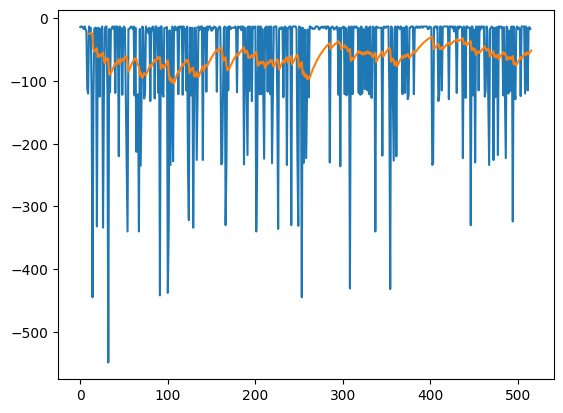

 SIGINT detected  training state is saved in memory 


In [38]:
agent.train(3000)

episode 500	(88.2/s)
time 5.67 s
---
average return -13.00000


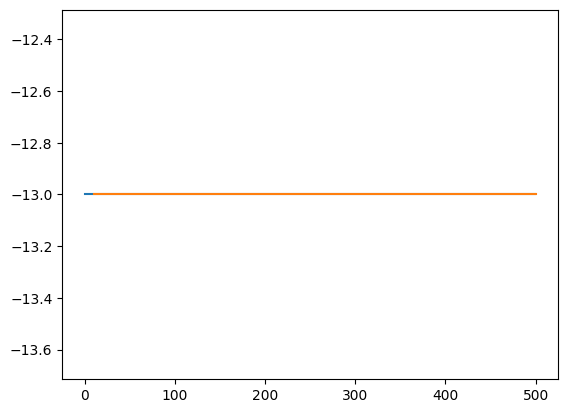

In [41]:
agent.eval()

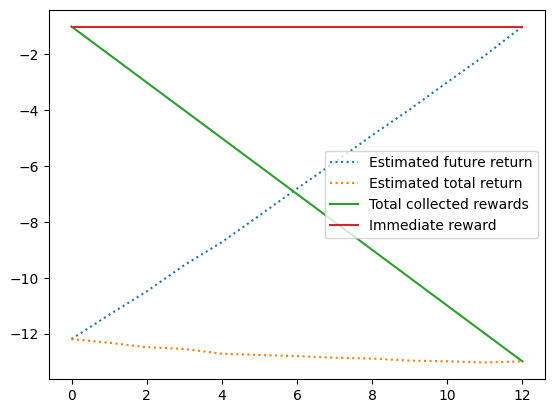

total rewards collected: -13


In [43]:
agent.play()

In [44]:
# save
agent.save(f'saved/{agent.env.spec.id}-DDQN-latest.pth')

In [45]:
agent.env.close()